<a target="_blank" href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/labs/08%20-%20Regression2/solutions/exercises_regression_2_sol.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<h1 align="center"> EXERCISE 8</h1>

<div>
<td> 
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Logo_Universit%C3%A9_de_Lausanne.svg/2000px-Logo_Universit%C3%A9_de_Lausanne.svg.png" style="padding-right:10px;width:240px;float:left"/></td>
<h2 style="white-space: nowrap">Business Intelligence and Analytics</h2></td>
<hr style="clear:both">
<p style="font-size:0.85em; margin:2px; text-align:justify">

</div>

# Exercise: Multivariate Linear Regression, Overfitting and Crossvalidation

This exercise is an application of what you learned in the walkthrough. The following cell gathers the different modules you need for this exercise (take a look at the sklearn library).

Some exercises consist of filling a part of the code without writing the whole code. Replace the `"YOUR CODE HERE"` by your own code.

In [12]:
# Useful starting lines
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
sns.set_style("darkgrid")

# Sklearn import
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.linear_model import LinearRegression # Regression linear model
from sklearn.model_selection import train_test_split # Splitting the data set
from sklearn.preprocessing import LabelEncoder #1-hot encoding
from sklearn.preprocessing import OneHotEncoder # Label encoding
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Metrics for errors
from sklearn.model_selection import KFold # Cross validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset
This week, we are going to use the `audi` dataset. Our task is to figure out how the different features have an influence the price of a car.
Load the pandas dataset from the given URL. Then display the first 5 rows. How many observations and columns do we have? 

In [13]:
url = 'https://media.githubusercontent.com/media/michalis0/Business-Intelligence-and-Analytics/master/data/audi.csv'
# Load the data
audi = pd.read_csv(url)
display(audi.head())

# Observations and columns (dimensions)
print("Number of observations", audi.shape[0])
print("Number of dimensions", audi.shape[1])

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


Number of observations 10668
Number of dimensions 9


An overview of the columns:
 * `price`: price in £
 * `model` : audi model
 * `year`: registration year
 * `transmission`: type of gearbox
 * `mileage`: distance used
 * `fuelType`: engine fuel
 * `tax` : road tax
 * `mpg`: miles per gallon
 * `engineSize`: size in litres
 
 We will try to predict the price using some of the other variables.

##Dealing with categorical variables
First we have to deal with our categorical variables. Since it's not possible to regress anything on them, we must transform them using techniques such as label encoding or 1-hot encoding. In this part, our goal is to obtain a final dataset :`AUDI` where there is no categorical variable.

Let's start with the `fuelType`. Since there are only 3 types of engine fuel, try to assign 0 for 'Petrol', 1 for 'Diesel' and 2 for 'Hybrid'. 

**Hint** use .replace()

In [14]:
audi['fuelType'] = audi['fuelType'].replace(['Petrol','Diesel','Hybrid'], [0,1,2])
display(audi.head())


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,0,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,1,20,64.2,2.0
2,A1,2016,11000,Manual,29946,0,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,1,145,67.3,2.0
4,A3,2019,17300,Manual,1998,0,145,49.6,1.0


Now, let's transform `model`. There are a lot of various models, thinking about what you've seen in last week lesson which technique should we use ?

In [15]:
#Label encoding 

X = audi[['model']]

X_label = X.apply(LabelEncoder().fit_transform)
del audi['model']

Lastly, let's tackle `transmission` using 1-hot encoding.

In [16]:
#1-hot encoding

#We create a DF with Dummy variables
dummies = pd.get_dummies(audi["transmission"])
X_hot = pd.concat([audi, dummies], axis = 1)

#We drop the transmission column 
del X_hot["transmission"]

display(X_hot.head())

,year,price,mileage,fuelType,tax,mpg,engineSize,Automatic,Manual,Semi-Auto
0,2017,12500,15735,0,150,55.4,1.4,0,1,0
1,2016,16500,36203,1,20,64.2,2.0,1,0,0
2,2016,11000,29946,0,30,55.4,1.4,0,1,0
3,2017,16800,25952,1,145,67.3,2.0,1,0,0
4,2019,17300,1998,0,145,49.6,1.0,0,1,0


Let's get an overview of our transformed dataset without categorical variables.

In [17]:
AUDI = pd.concat([X_hot, X_label], axis=1)
display(AUDI.head())

,year,price,mileage,fuelType,tax,mpg,engineSize,Automatic,Manual,Semi-Auto,model
0,2017,12500,15735,0,150,55.4,1.4,0,1,0,0
1,2016,16500,36203,1,20,64.2,2.0,1,0,0,5
2,2016,11000,29946,0,30,55.4,1.4,0,1,0,0
3,2017,16800,25952,1,145,67.3,2.0,1,0,0,3
4,2019,17300,1998,0,145,49.6,1.0,0,1,0,2


## Multivariate Regression
Now that our variables are usable  let's get to regression. Using the steps we covered last week, try to predict the `price` using our variables.

In [18]:
#We want to predict the price using other columns
y = AUDI["price"]
X = AUDI.drop("price", axis = 1)

In [19]:
#Split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

#Create the model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Performance metrics
print("Test scores: ")
print("MAE %.2f" % mean_absolute_error(y_test, predictions))
print("MSE %.2f" % mean_squared_error(y_test, predictions))
print("R^2 %.2f" % r2_score(y_test, predictions))

print("Train metrics")
print("params: ", model.coef_)
print("constant: ", model.intercept_)
print("R^2 score: ", model.score(X_train, y_train))

Test scores: 
MAE 3380.78
MSE 28747993.68
R^2 0.79
Train metrics
params:  [ 2.00510542e+03 -9.74001793e-02 -5.12966893e+02 -2.11739405e+01
 -1.70308265e+02  1.03592053e+04  7.92987327e+02 -1.15425080e+03
  3.61263478e+02  2.77074433e+02]
constant:  -4029060.8188128327
R^2 score:  0.7893349418473081


## Evaluation and Overfitting


### Overfitting
First, compute the mean absolute error of the training set and the testing set, save the values into the two arrays which are already defined. Plot the different errors values depending on the number of features.

Train error:  [6145.319561940547, 6050.195709735366, 5924.881741601926, 5220.992356659652, 4153.073518185361, 3458.8923403002814, 3453.3306910631377, 3415.98864978927, 3415.988649789262, 3363.4155561260864, 3363.4155561260864, 3363.4155561260864]
Test error :  [6040.77239524961, 5975.958667878962, 5918.8133958281, 5209.2995744700065, 4190.6996791361835, 3385.6058490091273, 3371.6467276849403, 3338.1693839487566, 3338.169383948742, 3302.949947346543, 3302.949947346543, 3302.949947346543]


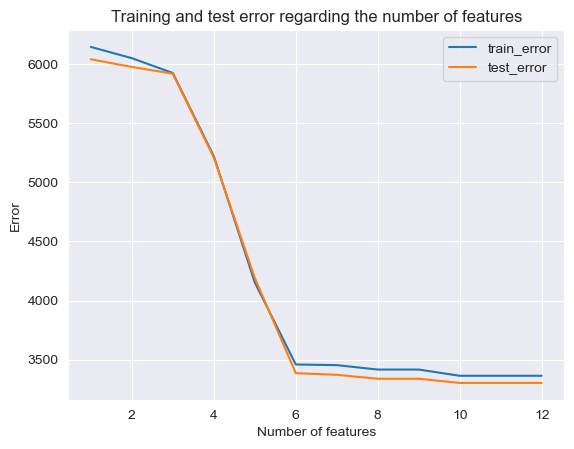

In [20]:
# Arrays to save the different errors
train_err = []
test_err = []

# Iterate over our features
for nbr_col in range(1, 13):
    # Select the good number of features for X
    X_temp = X[X.columns[:nbr_col]]
    # Split the dat set
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=10)
    # Create the linear model
    LR = LinearRegression(fit_intercept=True)
    # Fit the linear model
    LR.fit(X_train, y_train)
    
    #Compute and save the mean absolute error fro training and testing set
    train_err.append(mean_absolute_error(y_train, LR.predict(X_train)))
    test_err.append(mean_absolute_error(y_test, LR.predict(X_test)))

# Print the train and the test errors
print("Train error: ", train_err)
print("Test error : ", test_err)

plt.title("Training and test error regarding the number of features")
plt.plot(range(1,13), train_err, label="train_error")
plt.plot(range(1,13), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("Number of features")
plt.ylabel("Error")
plt.show()

###Cross validation
The standard way to do a hyperparameter tuning is through cross validation. We need to make sure that our model has a has a good generalisation power and performs well on unseen data. We use the KFold sklearn module to separate the data set into different combination of data. It will reduce the overfitting issue When you create a new KFold object, you have to specify the number of splits you want.

In [21]:
from sklearn.model_selection import KFold

y = AUDI["price"]
X = AUDI.drop("price", axis = 1)

kf = KFold(n_splits = 10, random_state = None)
model = LinearRegression()

mae_cumm = []
mse_cumm = []
r2_cumm = []

for train_index, test_index in kf.split(X):
  
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train, y_train)
  predictions = model.predict(X_test)


  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  mae_cumm.append(mae)
  mse_cumm.append(mse)
  r2_cumm.append(r2)

  
mean_mae = sum(mae_cumm)/len(mae_cumm)
mean_mse = sum(mse_cumm)/len(mse_cumm)
mean_r2 = sum(r2_cumm)/len(r2_cumm)

print("The mean absolute error of all our folds was: ",round(mean_mae, 3))
print("The mean squared error of all our folds was: ", round(mean_mse, 3))
print("The mean accuracy of all our folds was: ", round(mean_r2, 3))

The mean absolute error of all our folds was:  3402.054
The mean squared error of all our folds was:  30488591.2
The mean accuracy of all our folds was:  0.761
